In [1]:
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
from pprint import pprint
import random
from sklearn import preprocessing
from __future__ import division
import pickle
from pyproj import Proj, transform
from math import sqrt 
from datetime import datetime

# Load data from "uncorrupted" part of dataset
filename = '../data/parking_citations_uncorrupted.csv'
random.seed(42)

In [2]:
# Get headers and data types
columns = []
with open(filename) as f:
    reader = csv.reader(f)
    columns = reader.next()
    
names = [col.replace(" ","_") for col in columns]

dtypes = {
    'Ticket_number': 'unicode' ,
    'Issue_Date': 'unicode' ,
    'Issue_Time':'unicode'  ,
    'Meter_Id': 'unicode',
    'Marked_Time': 'unicode' ,
    'RP_State_Plate': 'unicode',
    'Plate_Expiry_Date': 'unicode' ,
    'VIN': 'unicode' ,
    'Make': 'unicode' ,
    'Body Style': 'unicode' ,
    'Color': 'unicode' ,
    'Location': 'unicode' ,
    'Route': 'unicode' ,
    'Agency': 'unicode' ,
    'Violation_Code': 'unicode' ,
    'Violation_Description': 'unicode' ,
    'Fine_amount': np.float64 ,
    'Latitude': np.float64 ,
    'Longitude': np.float64 ,
}

In [16]:
# Load data from file
citations = pd.read_csv(
    filename ,
    header = 0 ,
    names = names ,
    dtype = dtypes ,
)

In [17]:
# Optional: take a random sample for exploration purposes
citations = citations.sample(frac = 0.1, random_state=42)

In [18]:
# Label dataset by top 25 makes
top_25_makes = citations.groupby(['Make']).size().sort_values(ascending=False)
make_names = set(top_25_makes.index[:25])

citations['top_25_makes'] = citations['Make'].apply(lambda x: (x in make_names)*1)
citations['top_25_makes'] = citations['top_25_makes'].astype('category')

In [20]:
# Date formatting and coversion to days since epoch
citations['Issue_Date'] = pd.to_datetime(citations['Issue_Date'])

citations['Plate_Expiry_Date'] = citations['Plate_Expiry_Date'].fillna('')
citations['Plate_Expiry_Date'] = pd.to_datetime(citations['Plate_Expiry_Date'].str[:-2], format='%Y%M', errors='coerce')

citations['Issue_Date'] = (citations['Issue_Date'] - datetime(2000,01,01)).dt.days
citations['Plate_Expiry_Date'] = (citations['Plate_Expiry_Date'].fillna(datetime(2000,01,01)) - datetime(2000,01,01)).dt.days

#min_date = citations['Issue_Date'].min()

#citations['Issue_Date'] = citations['Issue_Date'] - min_date
#citations['Plate_Expiry_Date'] = citations['Plate_Expiry_Date'] - min_date

# Drop vars with too many NA's
drop_vars = [
    'VIN' ,
    'Marked_Time' ,
    'Meter_Id'
]
try:
    citations.drop(drop_vars , axis=1, inplace=True)
except KeyError:
    print("Already dropped columns.")

# Fill in nulls for continuous variables
citations['Issue_time'] = citations['Issue_time'].fillna(citations['Issue_time'].median())
citations['Fine_amount'] = citations['Fine_amount'].fillna(citations['Fine_amount'].median())
#citations['Plate_Expiry_Date'] = citations['Plate_Expiry_Date'].fillna(citations['Plate_Expiry_Date'].mode())

# Fill in nulls for categorical variables
categorical_vars = [
    'RP_State_Plate' ,
    'Body_Style' ,
    'Color' ,
    'Route' ,
    'Agency' ,
    'Violation_code' ,
    'Violation_Description' ,
    'Location'
]

for v in categorical_vars:
    print(v)
    citations[v] = citations[v].astype('category')
    citations[v] = citations[v].fillna(citations[v].mode().values[0])

RP_State_Plate
Body_Style
Color
Route
Agency
Violation_code
Violation_Description
Location


In [131]:
# Convert latitude/longitude into distance from center of LA
# Using US Feet Projection, should be Cartesian formula
# http://www.earthpoint.us/StatePlane.aspx, (34.0522,-118.2437)
la_lat = 6487847
la_lon = 1841468

citations['distance_from_la'] = ((citations['Latitude'] - la_lat)**2 + (citations['Longitude'] - la_lon)**2).apply(lambda x: sqrt(x))/5280

In [6]:
citations.describe(include='all')

,Ticket_number,Issue_Date,Issue_time,Meter_Id,Marked_Time,RP_State_Plate,Plate_Expiry_Date,VIN,Make,Body_Style,Color,Location,Route,Agency,Violation_code,Violation_Description,Fine_amount,Latitude,Longitude,top_25_makes
count,435754,435754,435648.000000,113890,14429,435708,396074,834,435754,435385,435609,435737,432587,435754,435754,435725,435438.000000,4.357540e+05,4.357540e+05,435754.0
unique,435754,1545,NaN,25134,720,73,402,650,424,56,54,229437,3272,22,199,274,NaN,NaN,NaN,2.0
top,4319282800,2016-01-19T00:00:00,NaN,37,800.0,CA,201606.0,NOT VISIBLE,TOYT,PA,BK,1301 ELECTRIC AVE,00600,54.0,80.69BS,NO PARK/STREET CLEAN,NaN,NaN,NaN,1.0
freq,1,500,NaN,2430,709,406030,8544,89,72371,383591,94329,498,25522,107187,121920,126241,NaN,NaN,NaN,398593.0
mean,NaN,NaN,1205.017321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.036993,5.498289e+06,1.585088e+06,NaN
std,NaN,NaN,472.289301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.898267,2.273469e+06,6.259822e+05,NaN
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000,9.999900e+04,9.999900e+04,NaN
25%,NaN,NaN,913.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.000000,6.421493e+06,1.821481e+06,NaN
50%,NaN,NaN,1156.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.000000,6.451529e+06,1.841958e+06,NaN
75%,NaN,NaN,1512.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.000000,6.475013e+06,1.858207e+06,NaN


In [8]:
# Check cardinality of categorical variables - all fairly high cardinality
for v in categorical_vars:
    print(v)
    print(len(citations[v].unique()))

RP_State_Plate
73
Body_Style
56
Color
54
Route
3272
Agency
22
Violation_code
199
Violation_Description
274
Location
229437


RP_State_Plate


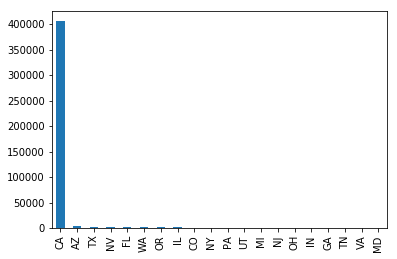

Body_Style


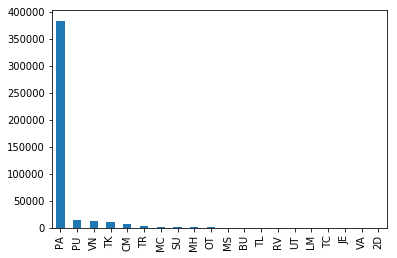

Color


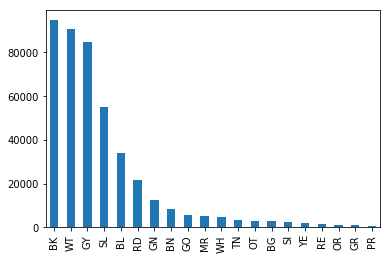

Route


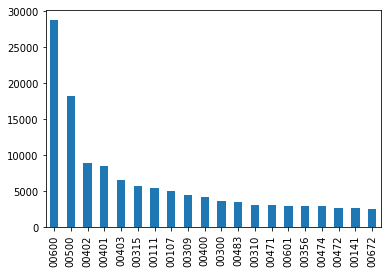

Agency


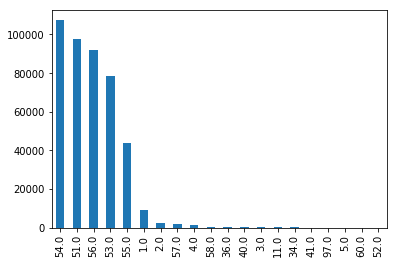

Violation_code


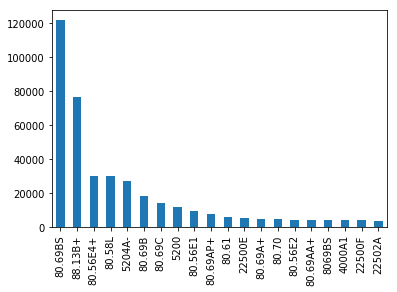

Violation_Description


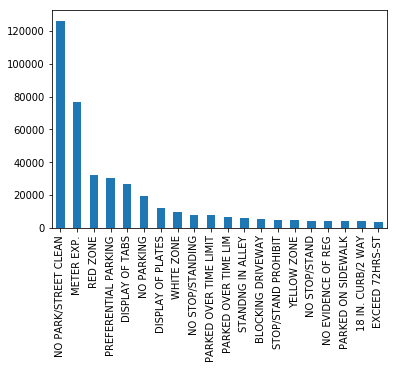

Location


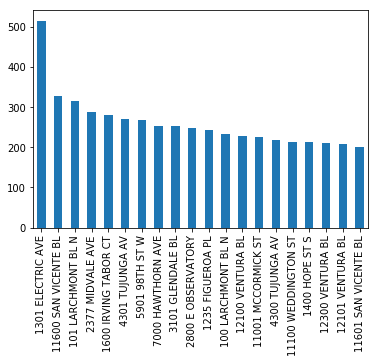

In [16]:
%matplotlib inline

# Check distribution of categorical vars
for v in categorical_vars:
    print(v)
    h = citations[v].value_counts()[:20].plot(kind='bar')
    plt.show(h)

In [103]:
# Label-encode all high cardinality categoricals - worked better than one-hot
categorical_vars = [
    'Agency' , 
    'Color' ,
    'Route' ,
    'Violation_code' ,
    'Violation_Description' ,
    'Location' ,
    'Body_Style' ,
    'RP_State_Plate'
]

for v in categorical_vars:
    print(v)
    le = preprocessing.LabelEncoder()
    le.fit(citations[v])
    citations[v] = le.transform(citations[v])


/home/ec2-user/grainger_data_science/env/lib/python2.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Agency
Color
Route
Violation_code
Violation_Description
Location
Body_Style
RP_State_Plate


In [179]:
feature_cols = [
    'Issue_Date' ,
    'Issue_time' ,
    'Plate_Expiry_Date' ,
    'Color' ,
    'Location' ,
    'Route' ,
    'Agency' ,
    'Violation_code' ,
    'Violation_Description' ,
    'Fine_amount' ,
    'Body_Style' ,
    'RP_State_Plate' ,
    'distance_from_la'
] 

target_cols = [
    'top_25_makes' ,
]

In [172]:
labels = np.array(citations[target_cols])
features = np.array(citations[feature_cols])


In [177]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Train-test split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

# Instantiate model with 100 decision trees
rf = RandomForestClassifier(
    n_estimators = 100, 
    random_state = 42,
    max_depth = 20 ,
)
# Train the model on training data
rf.fit(train_features, train_labels)

/home/ec2-user/grainger_data_science/env/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [178]:
# Summarize model scores
rf.score(test_features, test_labels)

0.9213963777894051

In [102]:
# Check skew of labels - compare to accuracy when guessing 1
split = (citations['top_25_makes'].value_counts()) / citations.shape[0]
print(split)

1    0.91472
0    0.08528
Name: top_25_makes, dtype: float64


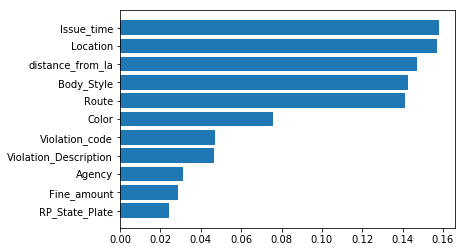

In [175]:
# Visualize feature importance
feature_importance = pd.DataFrame(
    rf.feature_importances_ ,
    index = feature_cols ,
    columns = ['importance'] ,
).sort_values('importance',ascending=False)


y_pos = np.arange(len(feature_importance.index))

fig, ax = plt.subplots()

ax.barh(y_pos, feature_importance['importance'], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_importance.index)
ax.invert_yaxis()


plt.show()

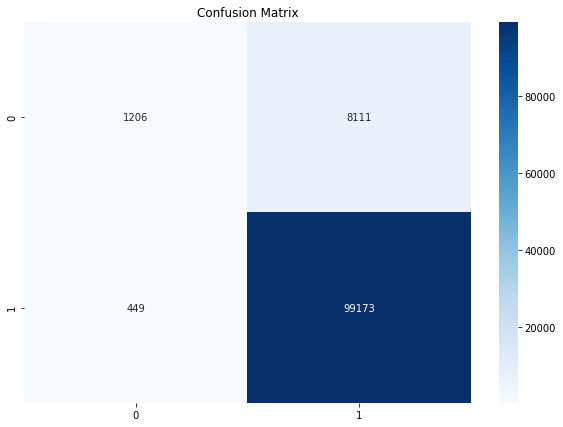

In [176]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

predictions = rf.predict(test_features)
confusion = confusion_matrix(y_true = test_labels, y_pred = predictions)

plt.figure(figsize=(10,7))
plt.title("Confusion Matrix")
sn.heatmap(confusion, annot=True, cmap='Blues', fmt='g')

In [180]:
print("Saving Model")

with open('../app/models/random_forest_classifier.pkl' ,'wb') as f:
    pickle.dump(rf, f)

Saving Model


In [5]:
citations.iloc[1]

Ticket_number                      4259370765
Issue_Date                2015-05-26T00:00:00
Issue_time                                807
Meter_Id                                  NaN
Marked_Time                               NaN
RP_State_Plate                             NE
Plate_Expiry_Date                    201508.0
VIN                                       NaN
Make                                     AUDI
Body_Style                                 PA
Color                                      BL
Location                     2914 PACIFIC AVE
Route                                   00131
Agency                                   51.0
Violation_code                        80.69BS
Violation_Description    NO PARK/STREET CLEAN
Fine_amount                                73
Latitude                                99999
Longitude                               99999
Name: 1066208, dtype: object

In [22]:
citations['Issue_Date'].mean()

6196.205971717987

In [23]:
citations['Plate_Expiry_Date'].mean()

5166.2038558452705